In [1]:
import torch
import segment_anything as sa
import cv2
import supervision as sv
from glob import glob
import matplotlib.pyplot as plt
import numpy as np

/home/flight/feedback/segment/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
def adapImshow(row: int, col: int, img: list):
    
    show = None

    if type(img[0]) is dict:
        show = [img[i]['segmentation'] for i in range(len(img))]
    else:
        show = img

    fig, axes = plt.subplots(row, col)
    
    if row == 1 and col ==1:
        axes.imshow(show)
        axes.set_title(str(0))
        axes.axis('off')
    elif row == 1:
        for i in range(len(show)):
            axes[i].imshow(show[i])
            axes[i].set_title(str(i))
            axes[i].axis('off')
    else:
        for i in range(row):
            for j in range(col):
                if (i*col)+j > len(show)-1:
                    break 
                axes[i][j].imshow(show[(i*col) + j])
                axes[i][j].set_title(str(i*col+j))
                axes[i][j].axis('off')

    plt.show()

In [3]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda:0


In [4]:

model = sa.sam_model_registry["vit_b"](checkpoint=r'sam_vit_b_01ec64.pth')
model = model.to(device=DEVICE)

In [70]:
mask_generator = sa.SamAutomaticMaskGenerator(
    model=model,
    points_per_batch=16,
    pred_iou_thresh=0.85,
    stability_score_thresh=0.85
    )

In [6]:
mask_annotator = sv.MaskAnnotator(color_map='index')

In [71]:
img = cv2.imread(r'./img/dataset/9.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
result = mask_generator.generate(img)

'''
result of mask_generator.generate(img)
Dict -> { 
    segmentation: np.array(image), 
    area: int, 
    bbox: list, 
    predicted_iou: float, 
    point_coords: 2D list, 
    stability_score: float, 
    crop_box: list 
}
'''

print(type(result))
print(result[0]['segmentation'])

<class 'list'>
[[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


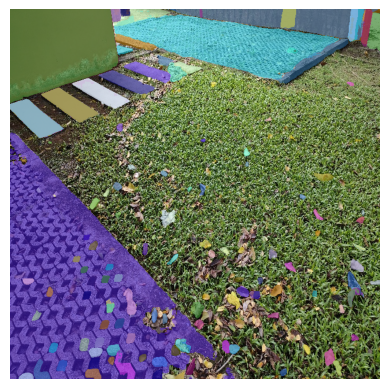

In [72]:
detection = sv.Detections.from_sam(result)
annotated_img = mask_annotator.annotate(img, detection)

plt.imshow(annotated_img)
plt.axis('off')
plt.show()

In [52]:
def mean(re: list):
    summ = 0
    for i in re:
        summ += i['area']
    return int(summ/len(re))

print(mean(result))
print(len(result))

3051
142


In [61]:
dataset = []
for i in result:
    if i['area'] < 3500:
        continue
    dataset.append(np.array(i['segmentation'], dtype=np.int8))

In [62]:
len(dataset)

2

In [19]:
'''
Here we set

0 -> background

1 -> grass plan

2 - > footpath
'''

'\nHere we set\n\n0 -> background\n\n1 -> grass plan\n\n2 - > footpath\n\n'

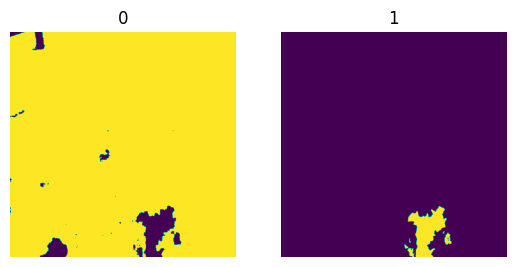

In [63]:
adapImshow(1, 2, dataset)

In [18]:
def get_mask(class1 = np.zeros((640, 640, 1), dtype=np.int8), class2 = np.zeros((640, 640, 1), dtype=np.int8)):
    mask = cv2.bitwise_or(class1, class2)
    adapImshow(1, 3, [class1, class2, mask])
    return mask

def merge(imgs: list):
    m_img = np.zeros((640, 640, 1), dtype=np.int8)
    for i in imgs:
        m_img = cv2.bitwise_or(m_img, i)
    return m_img

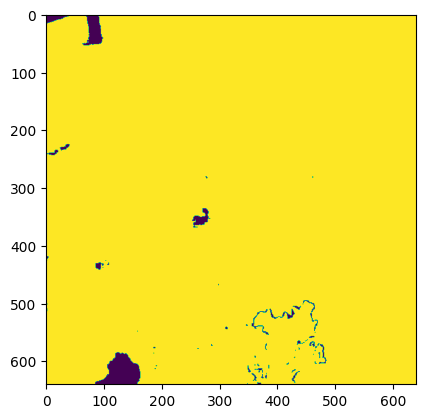

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


In [65]:
dirt_ground = merge(dataset)

plt.imshow(dirt_ground)
plt.show()

print(dirt_ground)

In [19]:
mask_frac = {}

for i in sorted(glob(r'./img/_label/*.png')):
    filename = i.split('/')
    filename = filename[len(filename)-1]
    key, ty = filename.split('-')[0], filename.split('-')[1].split('.')[0] 

    source = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    
    if mask_frac.get(key) is None:
        mask_frac[key] = []
    
    if ty == 'grass':
        mask_frac[key].append(np.array(np.array(source, dtype=np.bool_), dtype=np.int8))
    elif ty == 'footpath':
        mask_frac[key].append(np.array(np.array(source, dtype=np.bool_), dtype=np.int8)*2)

print(mask_frac)


{'10': [array([[2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]], dtype=int8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)], '11': [array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]], dtype=int8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)], '12': [array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       .

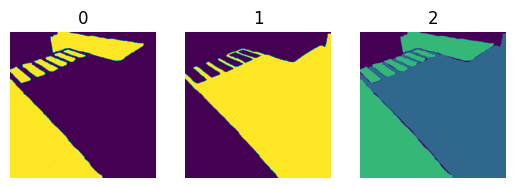

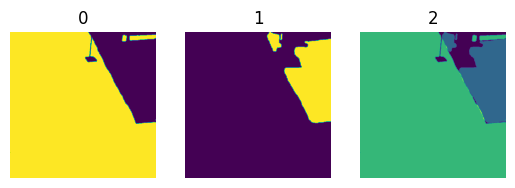

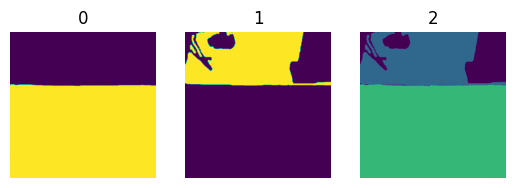

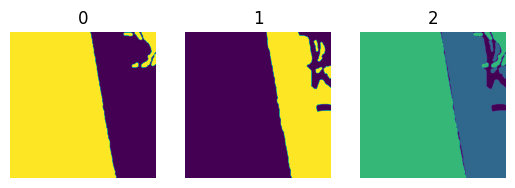

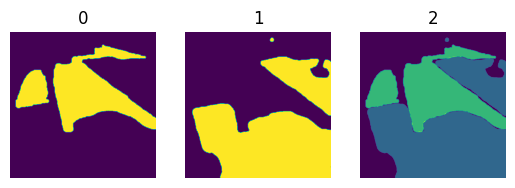

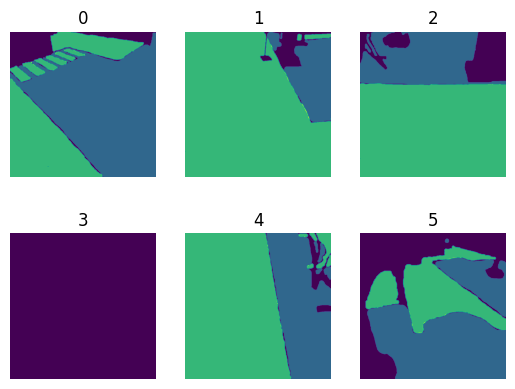

In [20]:
name = [9, 10, 11, 12, 13, 14]
new_mask = []

for i in name:
    filename = str(i)

    if len(mask_frac[filename]) == 1:
        new_mask.append(mask_frac[filename][0])
    else:
        new_mask.append(get_mask(mask_frac[filename][0], mask_frac[filename][1]))

adapImshow(2, 3, new_mask)

In [22]:
for i in new_mask:
    name = len(glob(r'./img/mask/*.png'))
    cv2.imwrite(f'./img/mask/{name}.png', i)

In [23]:
def show_mask(mask, ax):
    color = [np.concatenate([np.random.random(3), np.array([0.6])], axis=0) for i in range(2)]
    h, w = mask.shape[-2:]
    mask_1 = np.where(mask == 1, mask, 0)
    mask_img1 = mask_1.reshape(h, w, 1) * color[0].reshape(1, 1, -1)
    ax.imshow(mask_img1)
    mask_2 = np.where(mask == 2, 1, 0)
    mask_img2 = mask_2.reshape(h, w, 1) * color[1].reshape(1, 1, -1)
    ax.imshow(mask_img2)


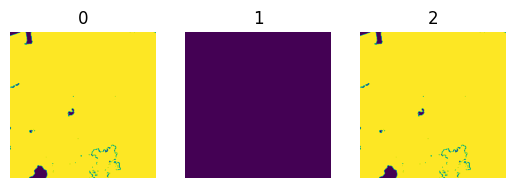

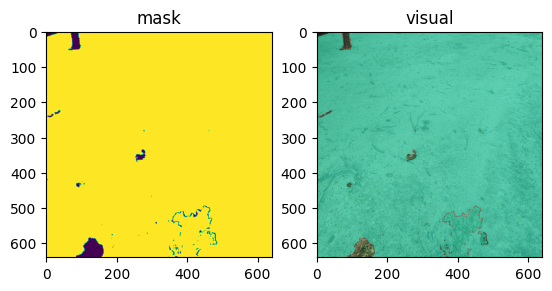

In [66]:
train_img = get_mask(dirt_ground)

fig , axes = plt.subplots(1, 2)

axes[0].imshow(train_img)
axes[0].set_title('mask')
axes[1].imshow(img)
axes[1].set_title('visual')

show_mask(train_img, axes[1])

plt.show()

In [67]:
# Save the mask dataset
name = len(glob(r'./img/mask/*.png'))
cv2.imwrite(f'./img/mask/{name}.png', train_img)

True

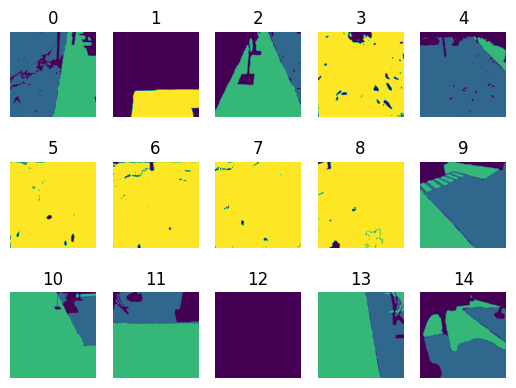

In [25]:
# masks = [cv2.imread(i, cv2.IMREAD_GRAYSCALE) for i in sorted(glob(r'./img/mask/*.png'))]
order = [i for i in range(15)]
masks = [cv2.imread(f'./img/mask/{i}.png', cv2.IMREAD_GRAYSCALE) for i in order]

adapImshow(3, 5, masks)

In [8]:
## temp sigel class mask

order = [i for i in range(15)]
masks = [cv2.imread(f'./img/mask/{i}.png', cv2.IMREAD_GRAYSCALE) for i in order]

for i, im in enumerate(masks):
    im = np.where(im == 2, 1, im)
    masks[i] = im
    cv2.imwrite(f'./img/mask_1c/{i}.png', im)